<a href="https://colab.research.google.com/github/eerubio/Cloud-Compute/blob/main/Actividad_2_1_Detecci%C3%B3n_de_Carriles_Equipo11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

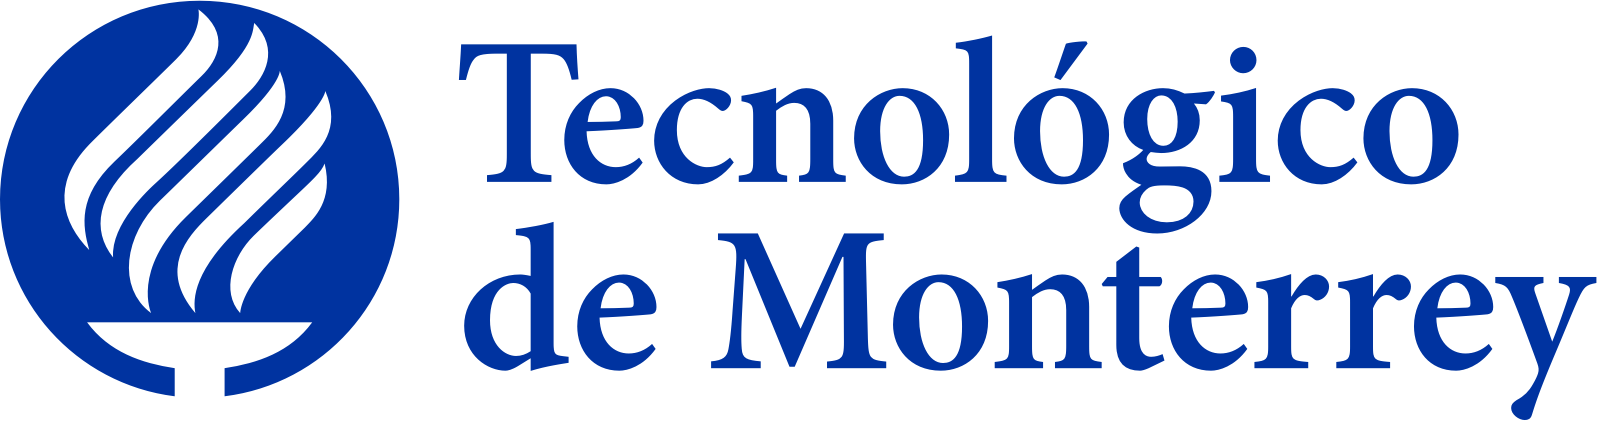

#**Maestría en Inteligencia Artificial Aplicada**
##**Tecnológico de Monterrey**
###**Navegacón Autónoma MR4010.10**
###**Prof. David Antonio Torres**
###**Prof. aux. Rafael Enrique Mendoza Crespo**
###**Prof. aux. Emmanuel Torres Rios**
###**Prof. aux. Maricarmen Vázquez Rojí**

## **Semanas 03 - 07/05/2023**

#**Actividad 2.1 - Detección de carriles en video usando transformada de Hough**

##**Bryan Rodolfo Alvarado Cruz A01793670**
##**José Ariel Corral León A01793546**
##**Ernesto Enríquez Rubio A01228409**
##**Lazaro Lara Martínez A01793198**

###**Instalación de librerias y dependencias**

In [ ]:
!pip install opencv-python
!pip install opencv-python-headless

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###**Importar las librerias necesarias**

In [ ]:
# Requerido para el procesamiento de imagenes
import cv2
# Requerida para 
import numpy as np
import matplotlib.pyplot as plt
import sys


Leer el video usando OpenCV:
Utilizaremos un video por default, pero habilitamos la opción para poder pasar el nombre de otro video por el usuario

In [ ]:
if len(sys.argv) == 2:
    video_name = sys.argv[1]
elif len(sys.argv) == 1:
    video_name = 'test_video.mp4'
else:
    raise Exception('Invalid Arguments')

# Cargamos el video con OpenCV
cap = cv2.VideoCapture(video_name)
cv2.namedWindow('image')
cv2.namedWindow('EdgeDetector')

In [ ]:
def nothing():
  pass

Definir los puntos de referencia para la región de interés (ROI) en la imagen del video. La ROI es la región en la que se buscarán los carriles:

In [ ]:
# Definir puntos de referencia para la región de interés
height, width = cap.read()[1].shape[:2]

# Definimos la ubicación de los vértices del área de interés
# Estos fueron estimados en base a pruebas con el objectivo de que
# la imagen de la carretera siempre se encuentre dentro de esta.
# En este caso se optó por un tríangulo.
# En caso de querer utilizar otro video o ajustar un poco el área de interés
# Se agregaron barras para hacer el ajusto mientras se esta procesando
# Para detectar mejor las lineas
cv2.createTrackbar('V1h', 'image', 0, height, nothing)
cv2.createTrackbar('V1w', 'image', 200, width, nothing)
cv2.createTrackbar('V2h', 'image', 0, height, nothing)
cv2.createTrackbar('V2w', 'image', 1100, width, nothing)
cv2.createTrackbar('V3h', 'image', int(height*.75), height, nothing)
cv2.createTrackbar('V3w', 'image', int(width*.5), width, nothing)



In [ ]:
def draw_lines(frame, lines):
    """
    Esta función toma una imagen de entrada y una lista de líneas, y dibuja las líneas en la imagen.
    """
    # Crear una imagen en negro para dibujar las líneas
    line_image = np.zeros_like(frame)

    # Dibujar cada línea en la imagen
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)

    # Combinar la imagen con las líneas con la imagen de entrada utilizando una operación bitwise OR
    line_frame = cv2.addWeighted(frame, 0.8, line_image, 1, 0.0)

    return line_frame

Crear una función para procesar cada cuadro del video. La función debe realizar las siguientes tareas:
Definir la ROI utilizando los puntos de referencia definidos anteriormente.
Convertir la imagen de entrada a escala de grises.
Aplicar un filtro gaussiano para suavizar la imagen y reducir el ruido.
Utilizar el operador Canny para detectar los bordes de los carriles.
Utilizar la transformada de Hough para detectar las líneas en la imagen.
Dibujar las líneas detectadas en la imagen de salida.

In [ ]:
def process_frame(frame, edges=None):
    # Definir la ROI utilizando los puntos de referencia definidos anteriormente
    mask = np.zeros_like(frame)

    # Convertir los puntos de la ROI a un tipo de datos adecuado y verificar la forma del vector de entrada
    vertices = np.array([ROI_vertices], dtype=np.int32)
    #if vertices.shape != (1, 4, 2):
     #   raise ValueError('ROI vertices must have shape (1, 4, 2)')

    cv2.fillPoly(mask, vertices, (255, 255, 255))
    masked_frame = cv2.bitwise_and(frame, mask)

    # Convertir la imagen de entrada a escala de grises
    gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)

    # Aplicar un filtro gaussiano para reducir el ruido
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Detectar los bordes de la imagen utilizando el operador Canny
    edges = cv2.Canny(blur, threshold1=50, threshold2=150)

    # Definir los parámetros de la transformada de Hough
    rho = 1  # Resolución en píxeles de la distancia rho
    theta = np.pi / 180  # Resolución en radianes del ángulo theta
    threshold = 15  # Umbral mínimo de votos para una línea
    min_line_length = 40  # Longitud mínima en píxeles de una línea
    max_line_gap = 20  # Máxima brecha en píxeles entre segmentos de línea para conectarlos en una sola línea

    # Ejecutar la transformada de Hough
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

    # Dibujar las líneas detectadas en la imagen de salida
    line_frame = draw_lines(frame, lines)

    return line_frame, edges


Procesar cada cuadro del video y mostrar la imagen de salida:

In [ ]:
# Procesar cada cuadro del video y mostrar la imagen de salida
while(cap.isOpened()):
    ret, frame = cap.read()

    if ret == True:
        # En caso de que el valor de las barras cambien, la región
        # de interés se actualizará y procesará el nuevo contenido
        v1h = cv2.getTrackbarPos('V1h', 'image')
        v1w = cv2.getTrackbarPos('V1w', 'image')
        v2h = cv2.getTrackbarPos('V2h', 'image')
        v2w = cv2.getTrackbarPos('V2w', 'image')
        v3h = cv2.getTrackbarPos('V3h', 'image')
        v3w = cv2.getTrackbarPos('V3w', 'image')
        
        ROI_vertices = [(v1w, 720-v1h), (v2w, 720-v2h), (v3w, 720-v3h)]
        line_frame, edges = process_frame(frame)

        cv2.imshow('EdgeDetector', edges)
        cv2.imshow('Video', line_frame)

        # Salir al presionar la tecla 'q'
        if cv2.waitKey(1) &  0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break
    else:
        cap.release()
        cv2.destroyAllWindows()
        break



**Video: [Detección de carriles](https://youtu.be/uowPf98UT3o/)**